## SFL 

#### With two arm bandit task and agents on a fully connected network


In [1]:
library(igraph)


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [148]:
N <- 10
net <- make_full_graph(N, directed=FALSE)

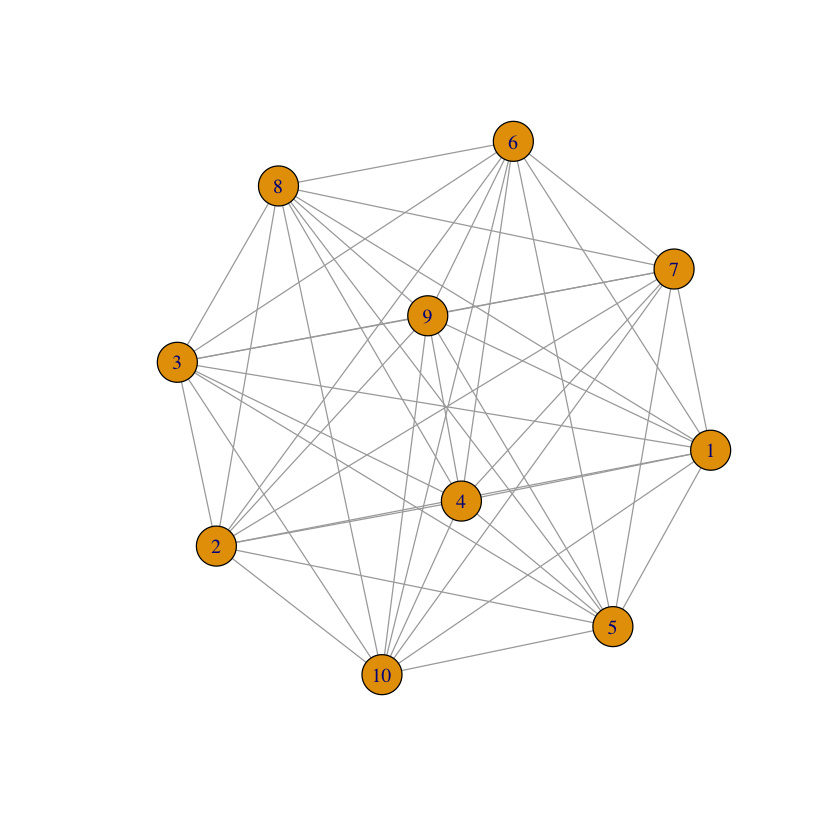

In [149]:
plot(net)

In [145]:
generate_features <- function(dimension_per_feat = 3, binary = TRUE) { 
  # features with mutually exclusive binary dimensions
  if(binary == TRUE){
    # for (i in 1:num_features) {
    grid <- expand.grid(rep(list(c(0, 1)), dimension_per_feat))  # unique combinations of dimensions for a feature

    feat_dim_unique_comb <- as.matrix(grid)
  } else{
    stop("Not yet")
  }
  return(feat_dim_unique_comb)
}


get_softmax <- function(q_values, beta) {
  exp_vals <- exp(q_values / beta)
  probs <- exp_vals / sum(exp_vals)
  return(probs)
}

# get_similarity <- function(feat_self, feat_other) {
#   return(if (feat_self == feat_other) 1 else 0) # basic check if feature has the same value or not
# }
print(generate_features())

     Var1 Var2 Var3
[1,]    0    0    0
[2,]    1    0    0
[3,]    0    1    0
[4,]    1    1    0
[5,]    0    0    1
[6,]    1    0    1
[7,]    0    1    1
[8,]    1    1    1


In [93]:
sample(2:3, 1)

[1] 3

In [141]:

simple_SFL <- function(N = 5, timesteps = 100,  num_arm = 2,
                       alpha = 0.01, beta = 1,
                       num_agent_feat = 1,
                       similar_agents = FALSE, 
                       dimension_per_feat = 3,
                       diversity_pool_size = NULL
                       ) { # nolint

  net <- make_full_graph(N, directed=FALSE)

  feat_val_pool <- generate_features(dimension_per_feat, binary = TRUE)

  feat_val_pool_size <- nrow(feat_val_pool)

  total_dim <- num_agent_feat * dimension_per_feat

  agent_features <- matrix(NA, nrow = N, ncol = total_dim)
  

  if(similar_agents) {

    # agents have the same feature values
    common_feature <- feat_val_pool[sample(6:feat_val_pool_size, 1), ] # here start from 6 to avoid the first feature with all zeros or only one dimension with 1

    # Replicate this common feature for each feature and for every agent
    agent_features <- matrix(rep(common_feature, num_agent_feat * N), nrow = N, byrow = TRUE)
  } else {
    if (is.null(diversity_pool_size)) diversity_pool_size <- feat_val_pool_size # default to full pool size

    # randomly sample a subset of feature values from the pool
    sampled_pool <- sample(1:feat_val_pool_size, size = diversity_pool_size, replace = FALSE)
    for(i in 1:N) {
      feature_vector <- c()
      for(j in 1:num_agent_feat) {

        #randomly sample one row from the feature value pool
        sampled_index <- sample(1:diversity_pool_size, 1) # start from 2 to avoid the first feature with all zeros
        sampled_feature <- feat_val_pool[sampled_pool[sampled_index], ]

            # determinstically sample a feature from the pool
            # sampled_feature <- feat_val_pool[sample(2:diversity_pool_size, 1), ] # start from 2 to avoid the first feature with all zeros

        feature_vector <- c(feature_vector, sampled_feature)
      }
      agent_features[i, ] <- feature_vector
    }
  }
  
  # weights for 2 arms + 1 observed choice + total_dim features
  weights <- matrix(0, nrow = N, ncol = num_arm + 1 + total_dim) 
  agent_last_choice <- rep(0, N)
  
  for (t in 1:timesteps) {

    for (i in 1:N) {

      # select a neighbor
      neighbors <- setdiff(1:N, i)
      chosen_neighbor <- sample(neighbors, 1)

      # binary similarity between agent i and neighbor
      # similarity_val <- get_similarity(agent_features[i], agent_features[chosen_neighbor])
      
      nb_features <- agent_features[chosen_neighbor, ]
      # simulate neighbor's choice
      nb_choice <- agent_last_choice[chosen_neighbor]
      
      # observed choice of neighbor
      nb_choice_val <- c(as.numeric(nb_choice == 1), as.numeric(nb_choice == 2))
      
      # non social feature value of arms
      intrinsic_arm1 <- c(1, 0)
      intrinsic_arm2 <- c(0, 1)
      
      # combined feature values of arms for agent i
      features_arm1 <- c(intrinsic_arm1, nb_choice_val[1], nb_features)
      features_arm2 <- c(intrinsic_arm2, nb_choice_val[2], nb_features)
      
      Q_arm1 <- sum(weights[i, ] * features_arm1)
      Q_arm2 <- sum(weights[i, ] * features_arm2)
      Q_values <- c(Q_arm1, Q_arm2)
      
      action_probs <- get_softmax(Q_values, beta)
      
      choice <- sample(1:2, size = 1, prob = action_probs)
      agent_last_choice[i] <- choice

      reward <- rbinom(1, 1, c(0.8, 0.2)[choice])

      
      # prediction error
      delta <- reward - Q_values[choice]
      
      # update weights for the chosen arm
      weights[i, ] <- weights[i, ] + alpha * delta * (if(choice == 1) features_arm1 else features_arm2)

    }
  }
  return(list(weights = weights,
              agent_last_choice = agent_last_choice,
              agent_features = agent_features,
              # feat_val_pool = feat_val_pool,
              diversity_pool_size = diversity_pool_size))
}

In [142]:

homogeneous <- simple_SFL(N = 100, timesteps = 1000, similar_agents = TRUE)
diverse <- simple_SFL(N = 100, timesteps = 1000, similar_agents = FALSE, diversity_pool_size = 7)

In [150]:
# agent counts for each feature value group
table(apply(homogeneous$agent_features, 1, paste, collapse = "-"))
table(apply(diverse$agent_features, 1, paste, collapse = "-"))


1-0-1 
  100 


0-0-1 0-1-0 0-1-1 1-0-0 1-0-1 1-1-0 1-1-1 
   17    17    19    10    13    13    11 

In [144]:
print(colMeans(homogeneous$weights))

print(colMeans(diverse$weights))

[1]  0.39452575 -0.19843966  0.02265482  0.19608609  0.00000000  0.19608609
[1]  0.54818552 -0.03147769  0.06794098  0.09216715  0.11432215  0.11926080
